In [1]:
import torch.nn as nn
import torch.optim as optim
import torch_geometric.utils
import torch, random, torchaudio, os, time, math, torch_geometric
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import networkx as nx
from torchvision import transforms as transforms
import torchaudio.transforms as audio_transforms
import datasets
from torch.utils.data import random_split, DataLoader
import utils

batch_size = 256
sample_rate = 16000
resample_rate = 8000
args = utils.Args(seed=42)

if args.device != "cpu":
    num_workers = 1
    pin_memory = True
    torch.cuda.manual_seed(args.seed)
else:
    num_workers = 0
    pin_memory = False
    torch.manual_seed(args.seed)

mimii_dataset = datasets.MIMII(root_dir='./data/mimii/-6dB_SNR', N=32, K=1, query_size=1)
train_size = int(0.005 * len(mimii_dataset))
test_size = len(mimii_dataset) - train_size
print(f"Train Size:{train_size}, Test Size:{test_size}")
train_dataset, test_dataset = random_split(mimii_dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=True)

Train Size:2, Test Size:544


波形形状: torch.Size([8, 160000])
波形采样率: 16000


/tmp/ipykernel_17870/1766157764.py:7: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538439675/work/aten/src/ATen/native/TensorShape.cpp:3697.)
  plt.plot(waveform[0].T.numpy())


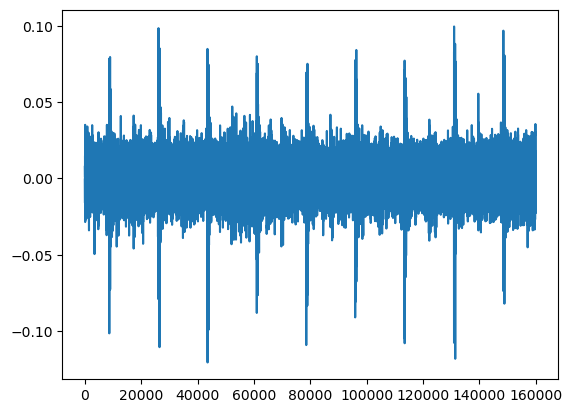

In [2]:
waveform_shape = 0
for support_set, _ in train_loader:
    for waveform, label in support_set:
        waveform = waveform.squeeze(0)
        print("波形形状: {}".format(waveform.size()))
        print("波形采样率: {}".format(sample_rate))
        plt.plot(waveform[0].T.numpy())
        waveform_shape = waveform.shape
        break
    break

AudioCNN架构:
AudioCNN(
  (conv1): Conv1d(8, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=32, 

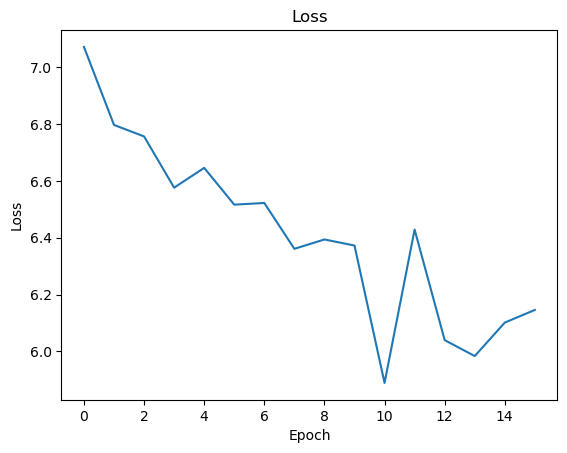

In [3]:
import nets

audio_cnn = nets.AudioCNN(num_channels_input=waveform_shape[0],
                          num_channels_hidden=32,
                          num_outputs=32)
print(f"AudioCNN架构:\n{audio_cnn}\n共有参数{audio_cnn.count_parameters()}")
utils.cnn_train(audio_cnn, 16, train_loader, args.device)

In [4]:
gcn = nets.GCN()
utils.graph_conv_train(gcn, audio_cnn, train_loader,
                       num_epochs=400, lr=0.05, device=args.device)

ZeroDivisionError: float division by zero